In [1]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform, he_uniform
from keras.utils.vis_utils import plot_model
tf.random.set_seed(27)

In [2]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")

In [3]:
print("Shape of the images: " + str(X_train[0].shape))
print("Example of measurement: " + str(y_train[0]))

Shape of the images: (76, 320, 3)
Example of measurement: -0.2


In [4]:
if not os.path.exists("models"): os.makedirs("models")

In [5]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(76, 320, 3),
    
)

inputs = keras.Input(shape=(76, 320, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

## Training Top Layer

In [6]:
base_model.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 76, 320, 3)]      0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 3, 10, 1280)       4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [7]:
epochs = 50
batch_size = 32
learning_rate = 0.0001

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss=keras.losses.mse,
              metrics=['mse'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mse',
                                                 factor=0.5,
                                                 patience=5,
                                                 min_lr=0.1*learning_rate,
                                                 verbose=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=2, verbose=1)

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping_callback],
                    shuffle=True,
                    epochs=epochs,
                    verbose=1)
end_epoch_top_layer_training = len(history.history['loss'])

Epoch 1/50
2629/2629 [==============================] - 67s 24ms/step - loss: 0.1706 - mse: 0.1706 - val_loss: 0.1109 - val_mse: 0.1109
Epoch 2/50
2629/2629 [==============================] - 60s 23ms/step - loss: 0.1205 - mse: 0.1205 - val_loss: 0.1063 - val_mse: 0.1063
Epoch 3/50
2629/2629 [==============================] - 59s 23ms/step - loss: 0.1102 - mse: 0.1102 - val_loss: 0.1052 - val_mse: 0.1052
Epoch 4/50
2629/2629 [==============================] - 60s 23ms/step - loss: 0.1065 - mse: 0.1065 - val_loss: 0.1041 - val_mse: 0.1041
Epoch 5/50
2629/2629 [==============================] - 60s 23ms/step - loss: 0.1048 - mse: 0.1048 - val_loss: 0.1067 - val_mse: 0.1067
Epoch 6/50
2629/2629 [==============================] - 61s 23ms/step - loss: 0.1043 - mse: 0.1043 - val_loss: 0.1038 - val_mse: 0.1038
Epoch 7/50
2629/2629 [==============================] - 60s 23ms/step - loss: 0.1038 - mse: 0.1038 - val_loss: 0.1031 - val_mse: 0.1031
Epoch 8/50
2629/2629 [==========================

## Fine tunning

In [8]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 76, 320, 3)]      0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 3, 10, 1280)       4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________


In [9]:
epochs = 20
batch_size = 32
learning_rate /= 10
filepath = "models/model_ft_{epoch:02d}_{val_mse:.4f}.h5"

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss=keras.losses.mse,
              metrics=['mse'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                            filepath=filepath,
                                            monitor='val_mse',
                                            mode='min',
                                            verbose=1,
                                            save_best_only=True)
history_ft = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping_callback, model_checkpoint_callback],
                    shuffle=True,
                    epochs=epochs,
                    verbose=1)

Epoch 1/20
2629/2629 [==============================] - 288s 107ms/step - loss: 0.0625 - mse: 0.0625 - val_loss: 0.0472 - val_mse: 0.0472

Epoch 00001: val_mse improved from inf to 0.04725, saving model to models\model_ft_01_0.0472.h5


c:\users\rodri\.conda\envs\sdcnd\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
2629/2629 [==============================] - 282s 107ms/step - loss: 0.0425 - mse: 0.0425 - val_loss: 0.0403 - val_mse: 0.0403

Epoch 00002: val_mse improved from 0.04725 to 0.04031, saving model to models\model_ft_02_0.0403.h5
Epoch 3/20
2629/2629 [==============================] - 284s 108ms/step - loss: 0.0379 - mse: 0.0379 - val_loss: 0.0374 - val_mse: 0.0374

Epoch 00003: val_mse improved from 0.04031 to 0.03738, saving model to models\model_ft_03_0.0374.h5
Epoch 4/20
2629/2629 [==============================] - 281s 107ms/step - loss: 0.0351 - mse: 0.0351 - val_loss: 0.0360 - val_mse: 0.0360

Epoch 00004: val_mse improved from 0.03738 to 0.03604, saving model to models\model_ft_04_0.0360.h5
Epoch 5/20
2629/2629 [==============================] - 288s 110ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0350 - val_mse: 0.0350

Epoch 00005: val_mse improved from 0.03604 to 0.03502, saving model to models\model_ft_05_0.0350.h5
Epoch 6/20
2629/2629 [======================

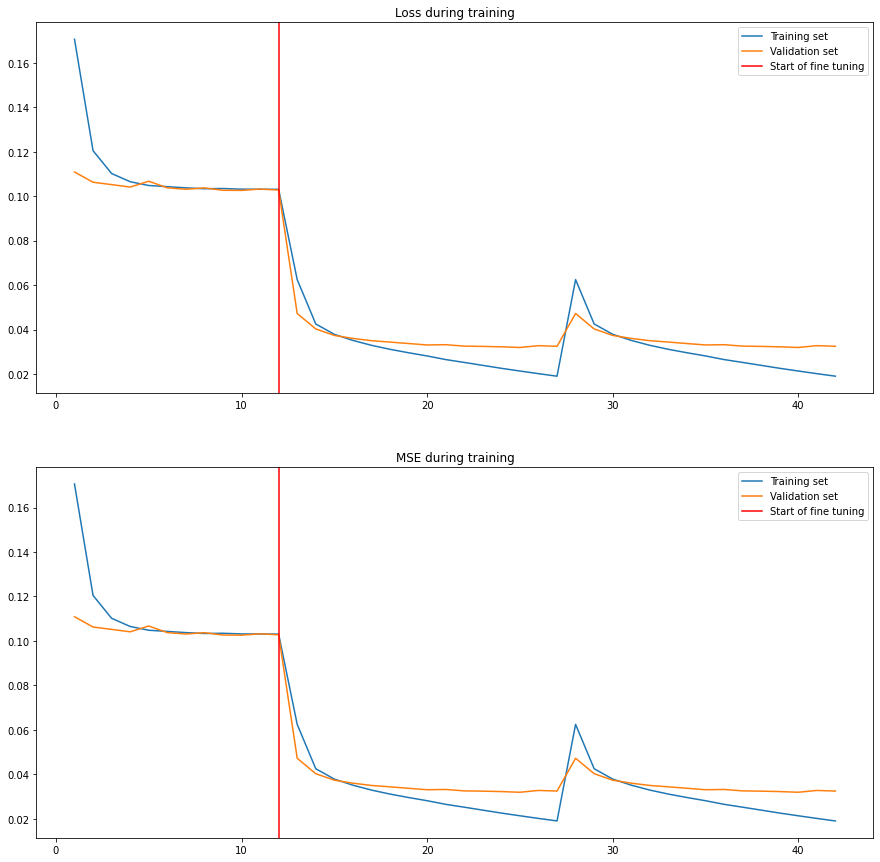

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))

history.history['loss'].extend(history_ft.history['loss'])
history.history['val_loss'].extend(history_ft.history['val_loss'])
history.history['mse'].extend(history_ft.history['mse'])
history.history['val_mse'].extend(history_ft.history['val_mse'])
epochs = np.arange(1, len(history.history['loss']) + 1)

axs[0].plot(epochs, history.history['loss'])
axs[0].plot(epochs, history.history['val_loss'])
axs[0].axvline(end_epoch_top_layer_training, color='r')
axs[0].title.set_text('Loss during training')
axs[0].legend(['Training set', 'Validation set', "Start of fine tuning"])

axs[1].plot(epochs, history.history['mse'])
axs[1].plot(epochs, history.history['val_mse'])
axs[1].axvline(end_epoch_top_layer_training, color='r')
axs[1].title.set_text('MSE during training')
axs[1].legend(['Training set', 'Validation set', "Start of fine tuning"])

plt.show()